In [ ]:
# default_exp core

# Ocetrac

> Track and label marine heatwaves from geospatial data. 

In [ ]:
#export
from nbdev.showdoc import *
import xarray as xr
import numpy as np
import scipy.ndimage
from skimage.measure import label, regionprops 
# import matplotlib.pyplot as plt 


## Functions

In [ ]:
#export
def _morphological_operations(da, radius=8): 
    '''Converts xarray.DataArray to binary, defines structuring element, and performs morphological closing then opening.
    Parameters
    ----------
    da     : xarray.DataArray
            The data to label
    radius : int
            Length of grid spacing to define the radius of the structing element used in morphological closing and opening.
        
    '''
    
    # Convert images to binary. All positive values == 1, otherwise == 0
    bitmap_binary = da.where(da>0, drop=False, other=0)
    bitmap_binary = bitmap_binary.where(bitmap_binary==0, drop=False, other=1)
    
    # Define structuring element
    diameter = radius*2
    x = np.arange(-radius, radius+1)
    x, y = np.meshgrid(x, x)
    r = x**2+y**2 
    se = r<radius**2

    def binary_open_close(bitmap_binary):
        bitmap_binary_padded = np.pad(bitmap_binary,
                                      ((diameter, diameter), (diameter, diameter)),
                                      mode='wrap')
        s1 = scipy.ndimage.binary_closing(bitmap_binary_padded, se, iterations=1)
        s2 = scipy.ndimage.binary_opening(s1, se, iterations=1)
        unpadded= s2[diameter:-diameter, diameter:-diameter]
        return unpadded
    
    mo_binary = xr.apply_ufunc(binary_open_close, bitmap_binary,
                               input_core_dims=[['lat', 'lon']],
                               output_core_dims=[['lat', 'lon']],
                               output_dtypes=[bitmap_binary.dtype],
                               vectorize=True,
                               dask='parallelized')
    
    return mo_binary


In [ ]:
#hide
################## TEST ##################

# Let's create a feature image set with 3 time steps and containing 5 different Gaussian blobs to test the morphological operations. 
# Three of these blobs will be spatially offset at each time step, but will still overlap. Two other blobs will appear at time step 3. 

# Create blobs
lon = np.arange(0, 360) + 0.5
lat = np.arange(-90, 90) + 0.5
x, y = np.meshgrid(lon, lat)

x0 = 180; x1 = 225; x2 = 360; x3 = 1; x4 = 80
y0 = 0; y1 = 20; y2 = -50; y4 = 40
sigma0 = 15; sigma1 = 25; sigma2 = 30; sigma4 = 10

blob0 = np.exp(-((x - x0)**2 + (y - y0)**2)/(2*sigma0**2))
blob1 = np.exp(-((x - x1)**2 + (y - y1)**2)/(2*sigma1**2))
blob2 = np.exp(-((x - x2)**2 + (y - y2)**2)/(2*sigma2**2))
blob3 = np.exp(-((x - x4)**2 + (y - y4)**2)/(2*sigma4**2))
blob4 = np.exp(-((x - x3)**2 + (y - y2)**2)/(2*sigma2**2))

da = xr.DataArray((blob0+blob1+blob3)-.5, dims=['lat', 'lon'],
                  coords={'lat': lat, 'lon': lon})
da_shift_01 = da.shift(lon=0, lat=-20, fill_value=-.5)
da_shift_02 = da.shift(lon=0, lat=-40, fill_value=-.5)+(blob2+blob4)
da_3D = xr.concat((da.expand_dims(dim='time'),
                   da_shift_01.expand_dims(dim='time'),
                   da_shift_02.expand_dims(dim='time')), dim='time')


# ##### A useful plot:
# da_3D[0,:,:].plot(vmin=-0.6, vmax=0.6, cmap='RdBu_r', extend='both')
# c1 = da_3D[0,:,:].plot.contour(levels=[0], colors='k', linewidths=2, linestyles=':')
# c2 = da_3D[1,:,:].plot.contour(levels=[0], colors='k', linewidths=2, linestyles='--')
# c3 = da_3D[2,:,:].plot.contour(levels=[0], colors='k', linewidths=2, linestyles='-')
# plt.arrow(80,40,0,-38, head_width=8, head_length=6, lw=2, color='magenta', zorder=4)
# plt.arrow(210,15,0,-38, head_width=8, head_length=6, lw=2, color='magenta', zorder=4)
# h1,_ = c1.legend_elements(); h2,_ = c2.legend_elements(); h3,_ = c3.legend_elements()
# plt.legend([h1[0], h2[0], h3[0]], ['t=0', 't=1', 't=2'])
# plt.title('Feature Field at t=0 \n Best Guess Objects Contoured at t=[0,1,2]', fontsize=14);


In [ ]:
#hide 
################## TEST ##################

# Now we will use Ocetrac to detect objects. 
# You can see, in this example, our best guess (shown previously) is pretty similar to Ocetrac (below)! 
# In the real world, these features are never perfectly Gaussian.

# Find edges of blobs using morphological image processing.
da_3D_dask = da_3D.chunk({'time': 1})
mo_binary = _morphological_operations(da_3D_dask, radius=8)
import dask.array as dsa
assert isinstance(mo_binary.data, dsa.Array)

In [ ]:
#hide
################## TEST ##################

# Now we can assert that Ocetrac and our best guess estimates overlap by at least 80% and that the sum of the Ocetrac detected pixels equals 17411.
ocetrac_blobs = da_3D.where(mo_binary==True, drop=False, other=np.nan) 
best_guess_blobs = da_3D.where(da_3D>0, drop=False, other=np.nan) 

part = ocetrac_blobs.isin(best_guess_blobs)
whole = best_guess_blobs.isin(best_guess_blobs)
assert part.sum()/whole.sum()*100 >= 80
assert part.sum() == 18050

In [ ]:
#hide
from skimage.measure import label as label_np

def _label_either(data, **kwargs):
    if isinstance(data, dsa.Array):
        try:
            from dask_image.ndmeasure import label as label_dask
            def label_func(a, **kwargs):
                ids, num = label_dask(a, **kwargs)
                return ids
        except ImportError:
            raise ImportError(
                "Dask_image is required to use this function on Dask arrays. "
                "Either install dask_image or else call .load() on your data."
            )
    else:
        label_func = label_np
    return label_func(data, **kwargs)


In [ ]:
#export
def _id(binary_images):
    '''label features from binary images'''
    
    labels, num = xr.apply_ufunc(
        label, 
        binary_images,
        kwargs={'return_num': True, 'connectivity': 2},
        input_core_dims=[['lat', 'lon', ]],
        output_core_dims=[['lat', 'lon'], []],
        output_dtypes=['i4', 'i4'],
        dask='parallelized',
        vectorize=True
    )

    #non_core_dims = set(binary_images.dims) - {'lat', 'lon'}
    # TODO: stop assuming 3D images
    offset = num.cumsum().shift(time=1, fill_value=0)
    unique_labels = xr.where(labels > 0, labels + offset, 0)
    return unique_labels

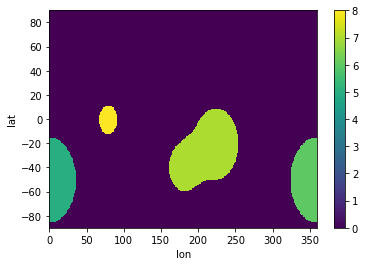

In [ ]:
# ID = _id(mo_binary)
# ID[2,:,:].plot()

In [ ]:
####### TEST: [TO DO] added time dimension ########


def _wrap(unique_labels):
    ''' Impose periodic boundary and wrap labels'''
    
    lon_0 = unique_labels.isel(lon=unique_labels.lon[0])
    lon_360 = unique_labels.isel(lon=unique_labels.lon[-1])
    
    for i in np.unique(lon_0) [np.unique(lon_0) != 0]:
        c = np.nonzero(lon_0.values == i)[0]
        values_360 = np.unique(lon_360[c]) [np.unique(lon_360[c]) != 0] #[0]
        wrap_labels = unique_labels.copy()
        wrap_labels[np.where(wrap_labels == values_360)] = i 
        
    return wrap_labels


def _relabel(wrap_labels):
    '''relabel objects with continuous IDs'''
    
    new_labels = xr.apply_ufunc(
        _wrap, 
        wrap_labels,
        input_core_dims=[['lat', 'lon', ]],
        output_core_dims=[['lat', 'lon'], []],
        output_dtypes=['i4','i4'],
        dask='parallelized',
        vectorize=True
    )
    
    new_labels = xr.DataArray(np.unique(new_labels, return_inverse=True)[1].reshape(new_labels.shape))

        
    return new_labels

## Toy data array
unique_labels = xr.DataArray(np.zeros((3, 10, 10), int), dims=['time','lat','lon'])
unique_labels[1:, :2, :2] = 1; unique_labels[:2, :5, -3:] = 8 
unique_labels[:, -2:, :3] = 5; unique_labels[:, -3:, -3:] = 14; 
unique_labels[-1, 5:7, 3:6] = 3

wrap_labels = _wrap(unique_labels[0,:,:])
new_labels = _relabel(wrap_labels)


ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [ ]:
#hide
################## TEST ##################

# Using the test data, let's label the objects we've identified. We should have 4 uniquely labeled blobs.
ID = _id(mo_binary)
assert isinstance(ID.data, dsa.Array)
ID.load()
assert ID[2,:,:].max() == 8.
assert all([i in ID[2,:,:] for i in range(5,9)])

In [ ]:
#export
def _wrap_labels(labels):
    '''wrap labels that cross prime meridian '''

    prime = labels.loc[dict(lon=labels.lon[:2])]

    prime_ids = np.unique(prime)[(~np.isnan(np.unique(prime)))&(np.unique(prime)>0)].astype('float')
    mirrormapBool = xr.DataArray(np.in1d(labels, prime_ids).reshape(labels.shape),
                                 dims=labels.dims,
                                 coords=labels.coords)
    earth2 = labels.where(mirrormapBool==True, drop=False, other=0)
    earth1 = labels.where(mirrormapBool==False, drop=False, other=0) # Remove label from origonal map
 
    # Concatenate and convert to binary
    res = labels.lon[1].values-labels.lon[0].values # resolution of longitude
    two_earths = xr.concat([earth1, earth2], dim='lon')
    two_earths['lon'] = np.arange(float(two_earths.lon[0].values),(two_earths.lon[-1].values*2)+res,res)
    bitmap_binary_2E = two_earths.where(two_earths>0, drop=False, other=0)
    bitmap_binary_2E = bitmap_binary_2E.where(bitmap_binary_2E==0, drop=False, other=1)
    bitmap_bool_2E = bitmap_binary_2E>0
    
    return bitmap_binary_2E, bitmap_bool_2E

In [ ]:
#hide

################## TEST ##################

# In our test image, there is a blob that is split across the prime meridian. 
# Ocetrac should be able to identify that these features belong together. 
bitmap_binary_2E, bitmap_bool_2E = _wrap_labels(ID)

# # # Let's relabel the wrapped blobs
ID_wrap = _id(bitmap_bool_2E)

# # # Ocetrac should only identify 3 events now at time 2.
assert ID_wrap[2,:,:].max() == 7.
assert all([i in ID_wrap[2,:,:] for i in range(5,8)])



In [ ]:
#export
def _id_area(labels, min_size_quartile):
    '''calculatre area with regionprops'''
    
    props = regionprops(labels.values.astype('int'))

    labelprops = [p.label for p in props]
    labelprops = xr.DataArray(labelprops, dims=['label'], coords={'label': labelprops}) 
    coords = [p.coords for p in props] # time, lat, lon

    area = []
    res = labels.lat[1].values-labels.lat[0].values # resolution of latitude
    for i in range(len(coords)):  
        area.append(np.sum((res*111)*np.cos(np.radians(labels.lat[coords[i][:,0]].values)) * (res*111)))
    area = xr.DataArray(area, dims=['label'], coords={'label': labelprops})  
    min_area = np.percentile(area, min_size_quartile*100)
    print('min area (km2) \t', min_area)  
    
    return area, min_area, labelprops

In [ ]:
#hide
################## TEST ##################

# Given the blobs detected by Ocetrac, what is the minimum area defined by computing the 75th percentile of the blob area distribution.
# Given this size criteria, only blob #2 is considered by Ocetrac.

# id_wrap = id_3D_wrap.where(id_3D_wrap!= 0, drop=False, other=np.nan)
min_size_quartile = .75

area, min_area, labelprops = _id_area(ID_wrap, min_size_quartile)
keep_labels = labelprops.where(area>=min_area, drop=True)
assert (area.label[area>=min_area] == keep_labels).all()

tot_area = int(np.sum(area.values))
small_area = area.where(area<=min_area, drop=True)
small_area = int(np.sum(small_area.values))
percent_area_kept = 1-(small_area/tot_area)
print('percent of total area kept = {}'.format(np.round(percent_area_kept*100,2)))
# Is the percent area kept less than or equal to the minimum size quantile?
assert percent_area_kept <= min_size_quartile


In [ ]:
#export
def track(da, radius=8, area_quantile=0.75):
    '''Image labeling and tracking.
    
    Parameters
    ----------
    da : xarray.DataArray
        The data to label.
    
    radius : int
        size of the structuring element used in morphological opening and closing.
        
    area_quantile : float
        quantile used to define the threshold of the smallest area object retained in tracking.
        
    Returns
    -------
    labels : xarray.DataArray
        Integer labels of the connected regions.
    '''
        
    # Converts data to binary, defines structuring element, and performs morphological closing then opening
    binary_images = _morphological_operations(da, radius=radius) 
    
    # label features from binary images
    ID = _id(binary_images)

    # wrap labels that cross prime meridian
    bitmap_binary_2E, bitmap_bool_2E = _wrap_labels(ID)
    
    ### ! Reapply land maks HERE
    
    # relabel 2D features from binary images that are wrapped around meridian
    ID_wrap = _id(bitmap_binary_2E)

    # calculatre area with regionprops
    area, min_area, labelprops = _id_area(ID_wrap, area_quantile)
    
    keep_labels = labelprops.where(area>=min_area, drop=True)

    ID_area_bool = xr.DataArray(np.isin(ID_wrap, keep_labels).reshape(ID_wrap.shape),
                               dims=ID_wrap.dims, coords=ID_wrap.coords)

    # Calculate Percent of total MHW area retained
    tot_area = int(np.sum(area.values))
    small_area = area.where(area<=min_area, drop=True)
    small_area = int(np.sum(small_area.values))
    percent_area_kept = 1-(small_area/tot_area)

    features = _id(ID_area_bool)
    features = features.rename('labels')
    features.attrs['min_area'] = min_area
    features.attrs['percent_area_kept'] = percent_area_kept
    print('inital features identified \t', int(features.max().values))
    
    ## Track labeled features
    bitmap_binary = features.where(features>0, drop=False, other=0)
    bitmap_binary = bitmap_binary.where(bitmap_binary==0, drop=False, other=1)
    
    ####### Label with Skimage
    # relabel
    label_sk3, final_features = label(bitmap_binary, connectivity=3, return_num=True)
    # explore scikit-image dask image
    
    label_sk3 = xr.DataArray(label_sk3, dims=['time','lat','lon'],
                          coords={'time': bitmap_binary.time, 'lat': bitmap_binary.lat,'lon': bitmap_binary.lon})
    binary_labels = label_sk3.where(label_sk3>0, drop=False, other=0)
    split_lon = int(binary_labels.shape[2]/2)
    origonal_map = binary_labels[:,:,split_lon:].values + binary_labels[:,:,:split_lon].values
    # Convert labels to DataArray

    labels = xr.DataArray(origonal_map, dims=['time','lat','lon'],
                          coords={'time': binary_images.time, 'lat': binary_images.lat,'lon': binary_images.lon})
    labels = labels.where(labels > 0, drop=False, other=np.nan)
    

    print('final features tracked \t', final_features)
    
    return labels

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
# this is the same as running nbdev_build_lib